<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [29]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [30]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [31]:
raw_html = urllib.request.urlopen('https://www.textos.info/oscar-wilde/el-retrato-de-dorian-gray/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, "html.parser")

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [32]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' el artista es creador de belleza. revelar el arte y ocultar al artista es la meta del arte. el crítico es quien puede traducir de manera distinta o con nuevos \r\nmateriales su impresión de la belleza. la forma más elevada de la \r\ncrítica, y también la más rastrera, es una modalidad de autobiografía. quienes descubren significados ruines en cosas hermosas están \r\ncorrompidos sin ser elegantes, lo que es un defecto. quienes encuentran \r\nsignificados bellos en cosas hermosas son espíritus cultivados. para \r\nellos hay esperanza. son los elegidos, y en su caso las cosas hermosas sólo significan belleza. no existen libros morales o inmorales. los libros están bien o mal escritos. eso es todo. la aversión del siglo por el realismo es la rabia de calibán al verse la cara en el espejo. la aversión del siglo por el romanticismo es la rabia de calibán al no verse la cara en un espejo. la vida moral del hombre forma parte de los temas del artista, pero \r\nla moralidad del arte consiste

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [33]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [34]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [35]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [36]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

65

In [37]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [38]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [39]:
tokenized_text[:1000]

[25,
 39,
 43,
 25,
 26,
 64,
 40,
 12,
 29,
 40,
 26,
 25,
 39,
 29,
 25,
 2,
 64,
 39,
 26,
 30,
 18,
 64,
 25,
 30,
 39,
 25,
 17,
 39,
 43,
 43,
 39,
 49,
 26,
 56,
 25,
 64,
 39,
 4,
 39,
 43,
 26,
 64,
 25,
 39,
 43,
 25,
 26,
 64,
 40,
 39,
 25,
 41,
 25,
 18,
 2,
 31,
 43,
 40,
 26,
 64,
 25,
 26,
 43,
 25,
 26,
 64,
 40,
 12,
 29,
 40,
 26,
 25,
 39,
 29,
 25,
 43,
 26,
 25,
 36,
 39,
 40,
 26,
 25,
 30,
 39,
 43,
 25,
 26,
 64,
 40,
 39,
 56,
 25,
 39,
 43,
 25,
 2,
 64,
 10,
 40,
 12,
 2,
 18,
 25,
 39,
 29,
 25,
 45,
 31,
 12,
 39,
 14,
 25,
 61,
 31,
 39,
 30,
 39,
 25,
 40,
 64,
 26,
 30,
 31,
 2,
 12,
 64,
 25,
 30,
 39,
 25,
 36,
 26,
 14,
 39,
 64,
 26,
 25,
 30,
 12,
 29,
 40,
 12,
 14,
 40,
 26,
 25,
 18,
 25,
 2,
 18,
 14,
 25,
 14,
 31,
 39,
 4,
 18,
 29,
 25,
 32,
 55,
 36,
 26,
 40,
 39,
 64,
 12,
 26,
 43,
 39,
 29,
 25,
 29,
 31,
 25,
 12,
 36,
 61,
 64,
 39,
 29,
 12,
 13,
 14,
 25,
 30,
 39,
 25,
 43,
 26,
 25,
 17,
 39,
 43,
 43,
 39,
 49,
 26,
 56,
 25,
 43

### Organizando y estructurando el dataset

In [40]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [41]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [42]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [43]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [44]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [45]:
X.shape

(419061, 100)

In [46]:
X[0,:10]

array([25, 39, 43, 25, 26, 64, 40, 12, 29, 40])

In [47]:
y[0,:10]

array([39, 43, 25, 26, 64, 40, 12, 29, 40, 26])

In [48]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [49]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, CategoryEncoding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import RMSprop, Adam

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [50]:
def create_model(cell_type='SimpleRNN', vocab_size=100, embedding_dim=200, dropout_rate=0.1, optimizer='rmsprop'):
    model = Sequential()
    model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None, 1)))

    if cell_type == 'SimpleRNN':
        model.add(SimpleRNN(embedding_dim, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    elif cell_type == 'LSTM':
        model.add(LSTM(embedding_dim, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    elif cell_type == 'GRU':
        model.add(GRU(embedding_dim, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    else:
        raise ValueError("cell_type must be 'SimpleRNN', 'LSTM', or 'GRU'")

    model.add(Dense(vocab_size, activation='softmax'))

    if optimizer == 'rmsprop':
        opt = RMSprop()
    elif optimizer == 'adam':
        opt = Adam()
    else:
        raise ValueError("optimizer must be 'rmsprop' or 'adam'")

    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)

    return model

In [51]:
model_simple_rnn = create_model(cell_type='SimpleRNN', vocab_size=vocab_size, embedding_dim=200, dropout_rate=0.1, optimizer='rmsprop')
model_simple_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, None, 65)          0         
 stributed)                                                      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 200)         53200     
                                                                 
 dense_3 (Dense)             (None, None, 65)          13065     
                                                                 
Total params: 66265 (258.85 KB)
Trainable params: 66265 (258.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
model_lstm = create_model(cell_type='LSTM', vocab_size=vocab_size, embedding_dim=200, dropout_rate=0.1, optimizer='rmsprop')
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 65)          0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, None, 200)         212800    
                                                                 
 dense_4 (Dense)             (None, None, 65)          13065     
                                                                 
Total params: 225865 (882.29 KB)
Trainable params: 225865 (882.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
model_gru = create_model(cell_type='GRU', vocab_size=vocab_size, embedding_dim=200, dropout_rate=0.1, optimizer='rmsprop')
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDi  (None, None, 65)          0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, None, 200)         160200    
                                                                 
 dense_5 (Dense)             (None, None, 65)          13065     
                                                                 
Total params: 173265 (676.82 KB)
Trainable params: 173265 (676.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [54]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5, model_name="my_model.keras"):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name
      self.history_ppl = history_ppl

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [55]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl1 = []
hist1 = model_simple_rnn.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl=history_ppl1,model_name="model_simple_rnn.keras")], batch_size=512)

Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 2.3019
 mean perplexity: 7.152972131984161 

Saved new model!
819/819 [==============================] - 315s 382ms/step - loss: 2.3019
Epoch 2/10
819/819 [==============================] - ETA: 0s - loss: 1.9899
 mean perplexity: 5.966267816464317 

Saved new model!
819/819 [==============================] - 298s 363ms/step - loss: 1.9899
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 1.8860
 mean perplexity: 5.519204873780896 

Saved new model!
819/819 [==============================] - 286s 349ms/step - loss: 1.8860
Epoch 4/10
819/819 [==============================] - ETA: 0s - loss: 1.8330
 mean perplexity: 5.282232225674113 

Saved new model!
819/819 [==============================] - 286s 349ms/step - loss: 1.8330
Epoch 5/10
819/819 [==============================] - ETA: 0s - loss: 1.8014
 mean perplexity: 5.121083301162832 

Saved new model!
819/819 [==============================] - 2

In [56]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl2 = []
hist2 = model_lstm.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl=history_ppl2,model_name="model_lstm.keras")], batch_size=512)

Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 2.5227
 mean perplexity: 8.910996158106421 

Saved new model!
819/819 [==============================] - 774s 943ms/step - loss: 2.5227
Epoch 2/10
819/819 [==============================] - ETA: 0s - loss: 2.1591
 mean perplexity: 7.74392895097573 

Saved new model!
819/819 [==============================] - 772s 943ms/step - loss: 2.1591
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 2.0602
 mean perplexity: 7.155585469320213 

Saved new model!
819/819 [==============================] - 771s 941ms/step - loss: 2.0602
Epoch 4/10
819/819 [==============================] - ETA: 0s - loss: 1.9992
 mean perplexity: 6.806392440201643 

Saved new model!
819/819 [==============================] - 768s 938ms/step - loss: 1.9992
Epoch 5/10
819/819 [==============================] - ETA: 0s - loss: 1.9523
 mean perplexity: 6.488247236159272 

Saved new model!
819/819 [==============================] - 76

In [57]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl3 = []
hist3 = model_gru.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl=history_ppl3,model_name="model_gru.keras")], batch_size=512)

Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 2.3520
 mean perplexity: 7.5866855948680385 

Saved new model!
819/819 [==============================] - 637s 776ms/step - loss: 2.3520
Epoch 2/10
819/819 [==============================] - ETA: 0s - loss: 1.9835
 mean perplexity: 6.264576657956259 

Saved new model!
819/819 [==============================] - 659s 805ms/step - loss: 1.9835
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 1.8180
 mean perplexity: 5.458373535033106 

Saved new model!
819/819 [==============================] - 681s 832ms/step - loss: 1.8180
Epoch 4/10
819/819 [==============================] - ETA: 0s - loss: 1.7052
 mean perplexity: 5.049553551280969 

Saved new model!
819/819 [==============================] - 666s 814ms/step - loss: 1.7052
Epoch 5/10
819/819 [==============================] - ETA: 0s - loss: 1.6304
 mean perplexity: 4.8102088712222715 

Saved new model!
819/819 [==============================] -

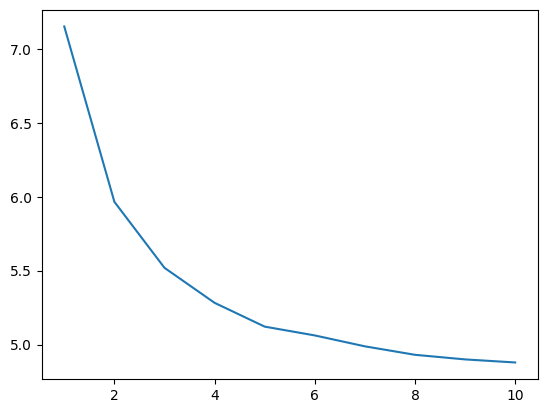

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl1) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl1)
plt.show()

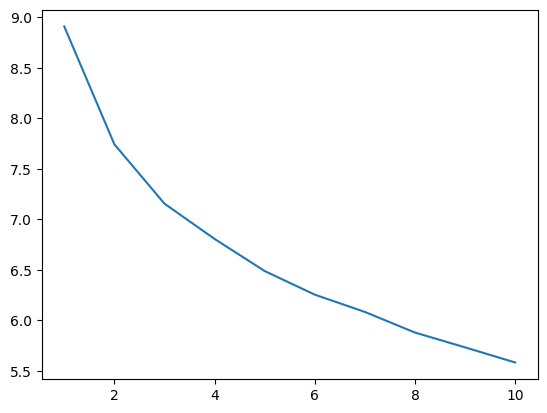

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl2) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl2)
plt.show()

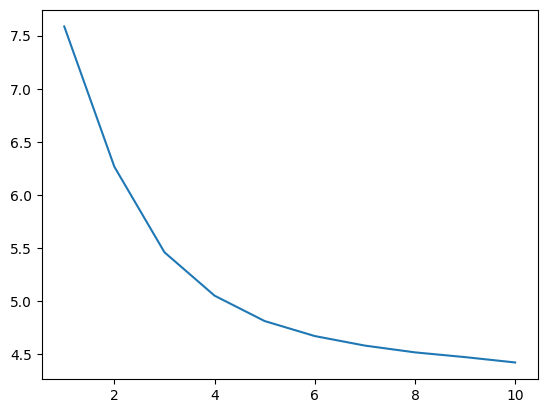

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl3) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl3)
plt.show()

In [62]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model1 = keras.models.load_model('model_simple_rnn.keras')

In [63]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model2 = keras.models.load_model('model_lstm.keras')

In [64]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model3 = keras.models.load_model('model_gru.keras')


### Predicción del próximo caracter

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

# !pip install -q gradio

In [ ]:
# import gradio as gr

# def model_response(human_text):

#     # Encodeamos
#     encoded = [char2idx[ch] for ch in human_text.lower() ]
#     # Si tienen distinto largo
#     encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

#     # Predicción softmax
#     y_hat = np.argmax(model2.predict(encoded)[0,-1,:])


#     # Debemos buscar en el vocabulario el caracter
#     # que corresopnde al indice (y_hat) predicho por le modelo
#     out_word = ''
#     out_word = idx2char[y_hat]

#     # Agrego la palabra a la frase predicha
#     return human_text + out_word

# iface = gr.Interface(
#     fn=model_response,
#     inputs=["textbox"],
#     outputs="text")

# iface.launch(debug=True)

### Generación de secuencias

In [65]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [69]:
input_text='el artis'

generate_seq(model1, input_text, max_length=max_context_size, n_words=40)

'el artista de la mano de la mano de la mano de l'

In [70]:
input_text='el artis'

generate_seq(model2, input_text, max_length=max_context_size, n_words=40)

'el artistas de la manor de la manor de la manor '

In [71]:
input_text='el artis'

generate_seq(model3, input_text, max_length=max_context_size, n_words=40)

'el artista de la mano en el persona en el person'

###  Beam search y muestreo aleatorio

In [72]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [73]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model1,num_beams=10,num_words=40,input="el artista",mode='sto')
salidas[0]
# veamos las salidas
decode(salidas[0])

'ááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááel artista de las mujeres que '

In [75]:
# predicción con beam search
salidas = beam_search(model2,num_beams=10,num_words=40,input="El artista",mode='sto')
salidas[0]
# veamos las salidas
decode(salidas[0])

'ááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááel artistamente de la vida de '

In [76]:
# predicción con beam search
salidas = beam_search(model3,num_beams=10,num_words=40,input="El artista",mode='sto')
salidas[0]
# veamos las salidas
decode(salidas[0])

'ááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááel artista de los ojos de los '

In [81]:
# predicción con beam search
salidas = beam_search(model1,num_beams=10,num_words=40,input="el artista",mode='det')
salidas[0]
# veamos las salidas
decode(salidas[0])

'ááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááel artista de las mujeres que '

In [82]:
# predicción con beam search
salidas = beam_search(model2,num_beams=10,num_words=40,input="el artista",mode='det')
salidas[0]
# veamos las salidas
decode(salidas[0])

'ááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááel artistamente de la vida de '

In [83]:
# predicción con beam search
salidas = beam_search(model3,num_beams=10,num_words=40,input="el artista",mode='det')
salidas[0]
# veamos las salidas
decode(salidas[0])

'ááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááel artista de los ojos de los '

## Conclusiones

Los modelos se conportan de igual manera en forma determinística y estocástica. 
Como es lógico, los tiempos de entrenamiento difieren en función de los modelos utilizados, obteniéndose en todos los casos modelos que en algún punto entran en un bucle que genera palabras repetidas, evidenciando la ineficiencia de estos modelos para generar LLMs.